<a href="https://colab.research.google.com/github/anshupandey/Generative-AI-for-Professionals/blob/main/Case_Study_Clothing_Matchmaker_Assistant_using_RAG_GPT4Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5: Clothing Match Maker Assistant using RAG with GPT4 Vision

Welcome to the Clothing Matchmaker App Jupyter Notebook! This project demonstrates the power of the GPT-4V model in analyzing images of clothing items and extracting key features such as color, style, and type. The core of our app relies on this advanced image analysis model developed by OpenAI, which enables us to accurately identify the characteristics of the input clothing item.

GPT-4V is a model that combines natural language processing with image recognition, allowing it to understand and generate responses based on both text and visual inputs.

Building on the capabilities of the GPT-4V model, we employ a custom matching algorithm and the RAG technique to search our knowledge base for items that complement the identified features. This algorithm takes into account factors like color compatibility and style coherence to provide users with suitable recommendations. Through this notebook, we aim to showcase the practical application of these technologies in creating a clothing recommendation system.

Using the combination of GPT-4 Vision + RAG (Retrieval-Augmented Generation) offers several advantages:

1. **Contextual Understanding**: GPT-4 Vision can analyze input images and understand the context, such as the objects, scenes, and activities depicted. This allows for more accurate and relevant suggestions or information across various domains, whether it's interior design, cooking, or education.
2. **Rich Knowledge Base**: RAG combines the generative capabilities of GPT-4 with a retrieval component that accesses a large corpus of information across different fields. This means the system can provide suggestions or insights based on a wide range of knowledge, from historical facts to scientific concepts.
3. **Customization**: The approach allows for easy customization to cater to specific user needs or preferences in various applications. Whether it's tailoring suggestions to a user's taste in art or providing educational content based on a student's learning level, the system can be adapted to deliver personalized experiences.

Overall, the GPT-4 Vision + RAG approach offers a powerful and flexible solution for various fashion-related applications, leveraging the strengths of both generative and retrieval-based AI techniques.

### Environment Setup

First we will install the necessary dependencies, then import the libraries and write some utility functions that we will use later on.

In [226]:
# pip install langchain-core>=0.3.63

In [227]:
# !pip install openai tenacity tqdm numpy typing tiktoken  langchain==0.3.25 langchain-core==0.3.60 --quiet
# concurrent

In [228]:
# pip install concurrent

In [229]:
# use approprite command if curl is not installed to download docs, option: wget
!curl -O https://raw.githubusercontent.com/anshupandey/Generative-AI-for-Professionals/main/datasets/sample_clothes.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
 15 30.0M   15 4688k    0     0  1646k      0  0:00:18  0:00:02  0:00:16 1648k
 57 30.0M   57 17.3M    0     0  4627k      0  0:00:06  0:00:03  0:00:03 4632k
100 30.0M  100 30.0M    0     0  6358k      0  0:00:04  0:00:04 --:--:-- 6366k


In [230]:
import zipfile

with zipfile.ZipFile("sample_clothes.zip", 'r') as zip_ref:
    zip_ref.extractall("sample_clothes")  # Creates a folder and extracts files

## Initializes a connection to Azure OpenAI service for chat completions.
### Configuration

- Client Type: AzureChatOpenAI
- Endpoint: Azure-hosted OpenAI service at clothassistant8618180812.openai.azure.com
- Authentication: API key retrieved securely from Azure Key Vault
- API Version: 2024-12-01-preview
- Model: Uses gpt-4 model for chat completions

In [ ]:
import pandas as pd
import numpy as np
import json
import ast
import tiktoken
import concurrent
from langchain_openai import AzureChatOpenAI
from tqdm import tqdm
from tenacity import retry, wait_random_exponential, stop_after_attempt
from IPython.display import Image, display, HTML
from typing import List
import os


GPT_MODEL = "gpt-4o-mini"
EMBEDDING_MODEL = "text-embedding-3-small"
EMBEDDING_COST_PER_1K_TOKENS = 0.00013
curr_path = os.getcwd()
# Make sure to initialize env variables: for azure openai endpoint, key, api version


# write code to initialize the Azure OpenAI Client

llm_call = AzureChatOpenAI(api_key= os.getenv("AZURE_OPENAI_API_KEY"),
        azure_endpoint= os.getenv("AZURE_OPENAI_ENDPOINT"),
        api_version=os.getenv("OPENAI_API_VERSION"),
        model=os.getenv("GPT_MODEL"),
        )
from langchain_openai import AzureOpenAIEmbeddings
emd_call = AzureOpenAIEmbeddings(api_key= os.getenv("AZURE_OPENAI_API_KEY"),
                                 azure_endpoint= os.getenv("AZURE_OPENAI_ENDPOINT"),
                                 api_version=os.getenv("OPENAI_API_VERSION"),
                                 model=os.getenv("EMBEDDING_MODEL"),)





### Creating the Embeddings
We will now set up the knowledge base by choosing a database and generating embeddings for it. I am using the `sample_styles.csv` file for this in the data folder. This is a sample of a bigger dataset that contains `~44K` items. This step can also be replaced by using an out-of-the-box vector database. For example, you can follow one of [these cookbooks](https://github.com/openai/openai-cookbook/tree/main/examples/vector_databases) to set up your vector database.

In [232]:
styles_filepath = os.path.join(curr_path, "sample_clothes", "sample_clothes", "sample_styles.csv")
styles_df = pd.read_csv(styles_filepath, on_bad_lines='skip')
print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt  
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts  
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt  
3  2012.0  Ethnic                  Fabindia Men Blue Kurta  
4  2012.0  Ethnic        Shree Women Multi Colored Patiala  
Opened dataset successfully. Dataset has 1000 items of clothing.


Now we will generate embeddings for the entire dataset. We can parallelize the execution of these embeddings to ensure that the script scales up for larger datasets. With this logic, the time to create embeddings for the full `44K` entry dataset decreases from ~4h to ~2-3min.

In [233]:
## Batch Embedding Logic
@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(10))
def get_embeddings(input: list):
    try:
        # write code to use openai client and create embeddings, use variable 'response' to store embeddings
        response = emd_call.embed_documents(input)
        return response
    except Exception as e:
        print(f"Error in get_embeddings: {str(e)}")
        raise

# Splits an iterable into batches of size n.
def batchify(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx : min(ndx + n, l)]

# Function for batching and parallel processing the embeddings
def embed_corpus(
    corpus: List[str],
    batch_size=64,
    num_workers=8,
    max_context_len=8191,
):
    # Encode the corpus, truncating to max_context_len
    encoding = tiktoken.get_encoding("cl100k_base")
    encoded_corpus = [
        encoded_article[:max_context_len] for encoded_article in encoding.encode_batch(corpus)
    ]

    # Calculate corpus statistics: the number of inputs, the total number of tokens, and the estimated cost to embed
    num_tokens = sum(len(article) for article in encoded_corpus)
    cost_to_embed_tokens = num_tokens / 1000 * EMBEDDING_COST_PER_1K_TOKENS
    print(
        f"num_articles={len(encoded_corpus)}, num_tokens={num_tokens}, est_embedding_cost={cost_to_embed_tokens:.2f} USD"
    )

    # Embed the corpus
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:

        futures = [
            executor.submit(get_embeddings, text_batch)
            for text_batch in batchify(corpus, batch_size)
        ]

        with tqdm(total=len(corpus)) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(batch_size)

        embeddings = []
        for future in futures:
            data = future.result()
            embeddings.extend(data)

        return embeddings


# Function to generate embeddings for a given column in a DataFrame
def generate_embeddings(df, column_name):
    # Initialize an empty list to store embeddings
    descriptions = df[column_name].astype(str).tolist()
    print(descriptions)
    embeddings = embed_corpus(descriptions)

    # Add the embeddings as a new column to the DataFrame
    df['embeddings'] = embeddings
    print("Embeddings created successfully.")

#### Two options for creating the embeddings:
The next line will **create the embeddings** for the sample clothes dataset. This will take around 0.02s to process and another ~30s to write the results to a local .csv file. The process is using our `text_embedding_3_large` model which is priced at `$0.00013/1K` tokens. Given that the dataset has around `1K` entries, the following operation will cost approximately `$0.001`. If you decide to work with the entire dataset of `44K` entries, this operation will take 2-3min to process and it will cost approximately `$0.07`.

**If you would not like to proceed with creating your own embeddings**, we will use a dataset of pre-computed embeddings. You can skip this cell and uncomment the code in the following cell to proceed with loading the pre-computed vectors. This operation takes ~1min to load all the data in memory.

In [234]:
generate_embeddings(styles_df, 'productDisplayName')
print("Writing embeddings to file ...")
styles_df.to_csv('sample_clothes/sample_styles_with_embeddings.csv', index=False)
print("Embeddings successfully stored in sample_styles_with_embeddings.csv")

['Mark Taylor Men Striped Blue Shirt', 'Flying Machine Men Yellow Polo Tshirts', 'U.S. Polo Assn. Men Checks Maroon Shirt', 'Fabindia Men Blue Kurta', 'Shree Women Multi Colored Patiala', 'Highlander Men Check White Shirt', 'Little Miss Intimates Grey & Black Pyjama Set', 'Nike Womens NIKE MILER SS TOP T-shirt', 'Puma Women Black Sweatshirt', "Tantra Women's Shlokas Blue T-shirt", 'ADIDAS Men Brown Mudslide Shoes', "Timberland Men's Wild Cats Cycle Grey T-shirt", 'Wrangler Women Blue Custom Jeans', 'Locomotive Men Printed Grey TShirt', 'Flying Machine Men Check Brown Shirts', 'Catwalk Women Casual Green Flats', 'Latin Quarters Women Beige Dress', 'Vishudh Women Brown Printed Kurta', 'W Women Printed White Kurtas', "Mr.Men Men's Surfer Chilly Pepper Maroon T-shirt", 'Quiksilver Men Grey Hammonds Cargo Shorts', 'Nike Women Solarsoft Thong Purple Flip Flops', 'Little Miss Women Printed Green T-shirt', 'Genesis Men Solid Brown Trousers', 'Puma Men Jago Ripstop White Sports Shoes', 'Nike Me

1024it [00:04, 244.30it/s]                         


Embeddings created successfully.
Writing embeddings to file ...
Embeddings successfully stored in sample_styles_with_embeddings.csv


In [235]:
styles_df = pd.read_csv('sample_clothes/sample_styles_with_embeddings.csv', on_bad_lines='skip')

# # Convert the 'embeddings' column from string representations of lists to actual lists of floats
styles_df['embeddings'] = styles_df['embeddings'].apply(lambda x: ast.literal_eval(x))

print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing along with their embeddings.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  \
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt   
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts   
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt   
3  2012.0  Ethnic                  Fabindia Men Blue Kurta   
4  2012.0  Ethnic        Shree Women Multi Colored Patiala   

                                          embeddings  
0  [0.032252050936222076, 0.051029108464717865, -...  
1  [0.028405755758285522, 0.044564101845026016, -...  

### Building the Matching Algorithm

In this section, we'll develop a cosine similarity retrieval algorithm to find similar items in our dataframe. We'll utilize our custom cosine similarity function for this purpose. While the `sklearn` library offers a built-in cosine similarity function, recent updates to its SDK have led to compatibility issues, prompting us to implement our own standard cosine similarity calculation.

If you already have a vector database set up, you can skip this step. Most standard databases come with their own search functions, which simplify the subsequent steps outlined in this guide. However, we aim to demonstrate that the matching algorithm can be tailored to meet specific requirements, such as a particular threshold or a specified number of matches returned.

The `find_similar_items` function accepts four parameters:
- `embedding`: The embedding for which we want to find a match.
- `embeddings`: A list of embeddings to search through for the best matches.
- `threshold` (optional): This parameter specifies the minimum similarity score for a match to be considered valid. A higher threshold results in closer (better) matches, while a lower threshold allows for more items to be returned, though they may not be as closely matched to the initial `embedding`.
- `top_k` (optional): This parameter determines the number of items to return that exceed the given threshold. These will be the top-scoring matches for the provided `embedding`.

In [236]:
import math
def cosine_similarity_manual(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""

    # implement the function which returns cosine similarity between two vectors.    
    # Calculate dot product
    dot_product = sum(a * b for a, b in zip(vec1, vec2))
    # Calculate magnitudes (norms)
    magnitude_1 = math.sqrt(sum(a * a for a in vec1))
    magnitude_2 = math.sqrt(sum(b * b for b in vec2))
    # Handle zero vectors
    if magnitude_1 == 0 or magnitude_2 == 0:
        return 0.0
    similarity_score = dot_product / (magnitude_1 * magnitude_2)
    return similarity_score

def find_similar_items(input_embedding, embeddings, threshold=0.5, top_k=2):
    """Find the most similar items based on cosine similarity."""

    # Calculate cosine similarity between the input embedding and all other embeddings
    similarities = [(index, cosine_similarity_manual(input_embedding, vec)) for index, vec in enumerate(embeddings)]

    # Filter out any similarities below the threshold
    filtered_similarities = [(index, sim) for index, sim in similarities if sim >= threshold]

    # Sort the filtered similarities by similarity score
    sorted_indices = sorted(filtered_similarities, key=lambda x: x[1], reverse=True)[:top_k]

    # Return the top-k most similar items
    return sorted_indices

In [237]:
def find_matching_items_with_rag(df_items, item_descs):
   """Take the input item descriptions and find the most similar items based on cosine similarity for each description."""

   # Select the embeddings from the DataFrame.
   embeddings = df_items['embeddings'].tolist()

   # Generate the embedding for the input item list
   input_embedding = get_embeddings(item_descs)

   similar_items = []
   for input_emb in input_embedding:  
      # Find the most similar items based on cosine similarity
      similar_indices = find_similar_items(input_emb, embeddings, threshold=0.6)
      similar_items += [df_items.iloc[i] for i,_ in similar_indices]

   return similar_items

### Analysis Module

In this module, we leverage `gpt-4-vision-preview` to analyze input images and extract important features like detailed descriptions, styles, and types. The analysis is performed through a straightforward API call, where we provide the URL of the image for analysis and request the model to identify relevant features.

To ensure the model returns accurate results, we use specific techniques in our prompt:

1. **Output Format Specification**: We instruct the model to return a JSON block with a predefined structure, consisting of:
   - `items` (str[]): A list of strings, each representing a concise title for an item of clothing, including style, color, and gender. These titles closely resemble the `productDisplayName` property in our original database.
   - `category` (str): The category that best represents the given item. The model selects from a list of all unique `articleTypes` present in the original styles dataframe.
   - `gender` (str): A label indicating the gender the item is intended for. The model chooses from the options `[Men, Women, Boys, Girls, Unisex]`.

2. **Clear and Concise Instructions**:
   - We provide clear instructions on what the item titles should include and what the output format should be. The output should be in JSON format, but without the `json` tag that the model response normally contains.

3. **One Shot Example**:
   - To further clarify the expected output, we provide the model with an example input description and a corresponding example output. Although this may increase the number of tokens used (and thus the cost of the call), it helps to guide the model and results in better overall performance.

By following this structured approach, we aim to obtain precise and useful information from the `gpt-4-vision-preview` model for further analysis and integration into our database.

In [ ]:
from langchain_core.messages import HumanMessage

def analyze_image(image_base64, subcategories):
    # Prepare the prompt and image inputs for AzureChatOpenAI
    messages = [
        HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": f"""Given an image of an item of clothing, analyze the item and generate a JSON output with the following fields: "items", "category", and "gender".
                           Use your understanding of fashion trends, styles, and gender preferences to provide accurate and relevant suggestions for how to complete the outfit.
                           The items field should be a list of items that would go well with the item in the picture. Each item should represent a title of an item of clothing that contains the style, color, and gender of the item.
                           The category needs to be chosen between the types in this list: {subcategories}.
                           You have to choose between the genders in this list: [Men, Women, Boys, Girls, Unisex]
                           Do not include the description of the item in the picture. Do not include the ```json ``` tag in the output.

                           Example Input: An image representing a black leather jacket.

                           Example Output: {{"items": ["Fitted White Women's T-shirt", "White Canvas Sneakers", "Women's Black Skinny Jeans"], "category": "Jackets", "gender": "Women"}}"""
                },
                {
                    "type": "image_url",
                    "image_url": {"url":f"data:image/jpg;base64,{image_base64}"}
                }
            ]
        )
    ]

    # Call the AzureChatOpenAI client to fetch send the messages and get response and return the response


    response = llm_call.invoke(messages)
    return response.content

### Testing the Prompt with Sample Images

To evaluate the effectiveness of our prompt, let's load and test it with a selection of images from our dataset. We'll use images from the `"data/sample_clothes/sample_images"` folder, ensuring a variety of styles, genders, and types. Here are the chosen samples:

- `2133.jpg`: Men's shirt
- `7143.jpg`: Women's shirt
- `4226.jpg`: Casual men's printed t-shirt

By testing the prompt with these diverse images, we can assess its ability to accurately analyze and extract relevant features from different types of clothing items and accessories.

We need a utility function to encode the .jpg images in base64

In [239]:
import base64

def encode_image_to_base64(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
        return encoded_image

In [245]:
# Set the path to the images and select a test image
image_path = os.path.join(curr_path, "sample_clothes", "sample_clothes", "sample_images")
test_images = ["2133.jpg", "7143.jpg", "4226.jpg"]

# Encode the test image to base64
reference_image = os.path.join(image_path, test_images[0])
encoded_image = encode_image_to_base64(reference_image)
encoded_image

'/9j/4AAQSkZJRgABAQAAZABkAAD/7AARRHVja3kAAQAEAAAAZAAA/9sAQwABAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQECAgEBAgEBAQICAgICAgICAgECAgICAgICAgIC/9sAQwEBAQEBAQEBAQEBAgEBAQICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIC/8AAEQgAUAA8AwERAAIRAQMRAf/EAB0AAAEEAwEBAAAAAAAAAAAAAAoABwgJAQULBgL/xAAxEAABBAICAgECBAUEAwAAAAACAQMEBQYHCBEAEgkTIQoUFTFBUWFxkTJygaEiI0L/xAAcAQABBAMBAAAAAAAAAAAAAAAABAUGBwIDCAH/xAA4EQABAwIEBAMFBgYDAAAAAAABAgMRAAQFEiExBkFRYRNxgQcUIpGxIzJCoeHwM1JigsHRFXKy/9oADAMBAAIRAxEAPwA/jwopeFFeK2PsTCtR4Dme0NjZDX4ngWvsYu8xzDJLQzCBSY5j1e/Z29lI+mBG4LUOO6qNtibrp+rTQG4YCvqUlSglIkqrwmBNCzO/i2eIr2yskxWs0fsqRgNfk7Nfh+zZV3XQo2c4sIGszI0xmVUty8Qle5B9GLPU2+myGZKimXTbiiwQoEqfymNDllJPYzMDmYohekAeU/XT/ca70TlobeOtuSundd731Bft5NrbaGMwcqxS5BpWDfgTPqNPRZkYiVYdpFnsTIkxhVUmJUF5klVQ7VA4hTa1IVunpt2I7Eaivdeehp3PMKKXhRS8KKXhRS8KKG+/FDYrsbLvjxw2nwvMMgx/F7DlDqGt25RU9mFNAzDX02Jlbo12STOveXURsqgY7Lbhqv0XZrEV50SWM0iaLt9dvZXbjMeOltRRPNQBIAHMmJjnEc6dsCsmr/F7C2uJFqt1vxSDGVsrSFKJ/CIMZuUzQ6eifio+P+94+3W

content='{"items": ["Light Blue Men\'s Jeans", "Brown Casual Leather Shoes", "White Cotton Capris"], "category": "Shirts", "gender": "Men"}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 8917, 'total_tokens': 8951, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_57db37749c', 'id': 'chatcmpl-Bi0MjVes7wBERUDWm4tGVXxv9oHxL', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_result': {'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}, 'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'custom_blocklists': {'filtered

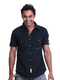

{'items': ["Light Blue Men's Jeans", 'Brown Casual Leather Shoes', 'White Cotton Capris'], 'category': 'Shirts', 'gender': 'Men'}


In [246]:
# Select the unique subcategories from the DataFrame
unique_subcategories = styles_df['articleType'].unique()

# Analyze the image and return the results
analysis = analyze_image(encoded_image, unique_subcategories)
image_analysis = json.loads(analysis)

# Display the image and the analysis results
display(Image(filename=reference_image))
print(image_analysis)

Next, we process the output from the image analysis and use it to filter and display matching items from our dataset. Here's a breakdown of the code:

1. **Extracting Image Analysis Results**: We extract the item descriptions, category, and gender from the `image_analysis` dictionary.

2. **Filtering the Dataset**: We filter the `styles_df` DataFrame to include only items that match the gender from the image analysis (or are unisex) and exclude items of the same category as the analyzed image.

3. **Finding Matching Items**: We use the `find_matching_items_with_rag` function to find items in the filtered dataset that match the descriptions extracted from the analyzed image.

4. **Displaying Matching Items**: We create an HTML string to display images of the matching items. We construct the image paths using the item IDs and append each image to the HTML string. Finally, we use `display(HTML(html))` to render the images in the notebook.

This cell effectively demonstrates how to use the results of image analysis to filter a dataset and visually display items that match the analyzed image's characteristics.

513Remaining Items
["Light Blue Men's Jeans", 'Brown Casual Leather Shoes', 'White Cotton Capris']


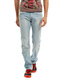

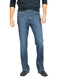

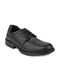

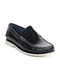

In [247]:
# Extract the relevant features from the analysis
item_descs = image_analysis['items']
item_category = image_analysis['category']
item_gender = image_analysis['gender']


# Filter data such that we only look through the items of the same gender (or unisex) and different category
filtered_items = styles_df.loc[styles_df['gender'].isin([item_gender, 'Unisex'])]
filtered_items = filtered_items[filtered_items['articleType'] != item_category]
print(str(len(filtered_items)) + "Remaining Items")

# Find the most similar items based on the input item descriptions
matching_items = find_matching_items_with_rag(filtered_items, item_descs)

# Display the matching items (this will display 2 items for each description in the image analysis)
html = ""
paths = []
for i, item in enumerate(matching_items):
    item_id = item['id']

    # Path to the image file
    image_path = os.path.join(curr_path, "sample_clothes", "sample_clothes", "sample_images", f'{item_id}.jpg')
    paths.append(image_path)
    html += f'<img src="{image_path}" style="display:inline;margin:1px"/>'

# Print the matching item description as a reminder of what we are looking for
print(item_descs)
# Display the image
for pth in paths:
  display(Image(filename=pth))

### Guardrails

In the context of using Large Language Models (LLMs) like GPT-4V, "guardrails" refer to mechanisms or checks put in place to ensure that the model's output remains within desired parameters or boundaries. These guardrails are crucial for maintaining the quality and relevance of the model's responses, especially when dealing with complex or nuanced tasks.

Guardrails are useful for several reasons:

1. **Accuracy**: They help ensure that the model's output is accurate and relevant to the input provided.
2. **Consistency**: They maintain consistency in the model's responses, especially when dealing with similar or related inputs.
3. **Safety**: They prevent the model from generating harmful, offensive, or inappropriate content.
4. **Contextual Relevance**: They ensure that the model's output is contextually relevant to the specific task or domain it is being used for.

In our case, we are using GPT-4V to analyze fashion images and suggest items that would complement an original outfit. To implement guardrails, we can **refine results**: After obtaining initial suggestions from GPT-4V, we can send the original image and the suggested items back to the model. We can then ask GPT-4V to evaluate whether each suggested item would indeed be a good fit for the original outfit.

This gives the model the ability to self-correct and adjust its own output based on feedback or additional information. By implementing these guardrails and enabling self-correction, we can enhance the reliability and usefulness of the model's output in the context of fashion analysis and recommendation.

To facilitate this, we write a prompt that asks the LLM for a simple "yes" or "no" answer to the question of whether the suggested items match the original outfit or not. This binary response helps streamline the refinement process and ensures clear and actionable feedback from the model.

In [255]:
from langchain_core.messages import HumanMessage
from pydantic import BaseModel, ValidationError, Field
from typing import Literal

class MatchResponse(BaseModel):
    """Pydantic model for validating the match response"""
    answer: Literal["yes", "no"] = Field(..., description="Whether the items match well together")
    reason: str = Field(..., min_length=10, max_length=250, description="Brief explanation of the decision")


def check_match(reference_image_base64, suggested_image_base64):
    # Prepare the prompt and image inputs for AzureChatOpenAI
    """
    Determines if two clothing items, represented by their base64-encoded images, would work well together in an outfit using an LLM-based vision model.

    Guidelines for implementing this function:
    1. **Inputs**:
        - `reference_image_base64` (str): Base64-encoded string of the reference clothing item image (the item to be matched).
        - `suggested_image_base64` (str): Base64-encoded string of the suggested clothing item image (the candidate match).

    2. **Prompt Construction**:
        - Construct a prompt that clearly instructs the model to compare the two clothing items and decide if they would work well together in an outfit.
        - The prompt should specify:
            - The first image is the reference item.
            - The second image is the suggested item.
            - The model must output a JSON object with two fields: "answer" (either "yes" or "no") and "reason" (a brief explanation).
            - The explanation should not include descriptions of the images themselves.
            - The output must not include the ```json``` tag.

    3. **Message Formatting**:
        - Use the `HumanMessage` class to format the prompt and attach both images as base64-encoded image URLs.
        - The message content should be a list containing:
            - The prompt text (as described above).
            - The reference image (as a dict with type "image_url" and the base64 string).
            - The suggested image (as a dict with type "image_url" and the base64 string).

    4. **Model Invocation**:
        - Use the AzureChatOpenAI client (assumed to be initialized as `client`) to send the message.
        - Set an appropriate `max_tokens` limit (e.g., 300) to ensure concise output.

    5. **Output Handling**:
        - Extract the model's response content.
        - Return the response as a string (expected to be a JSON object with "answer" and "reason").

    6. **Error Handling**:
        - Optionally, add error handling to manage cases where the model's response is not valid JSON or does not contain the expected fields.

    Example output:
        {
            "answer": "yes",
            "reason": "The suggested item complements the reference item in both color and style, making them suitable for an outfit together."
        }
    """
    # implement this function
    messages = [
        HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": """ You are a fashion expert tasked with determining if two clothing items would work well together in an outfit.

                    You will be shown two images:
                    1. The first image is the reference clothing item
                    2. The second image is the suggested clothing item to potentially match with the reference

                    Analyze both items and determine if they would work well together in an outfit based on:
                    - Color coordination and harmony
                    - Style compatibility 
                    - Seasonal appropriateness
                    - Overall aesthetic coherence
                    - Fashion principles and trends

                    Provide your response as a JSON object with exactly two fields:
                    - "answer": either "yes" or "no" 
                    - "reason": a brief explanation of your decision focusing on why they do or don't work together

                    Important guidelines:
                    - Do not describe what you see in the images
                    - Focus only on whether the items match well together
                    - Keep the reason concise and fashion-focused
                    - Output only the JSON object, no additional text or formatting
                    - Do not include ```json``` tags in your response

                    Example format: {"answer": "yes", "reason": "The colors complement each other well and the styles are compatible"}
                        
                    """
                },
                {
                    "type": "image_url",
                    "image_url": {"url":f"data:image/jpg;base64,{reference_image_base64}"}
                },
                {
                    "type": "image_url",
                    "image_url": {"url":f"data:image/jpg;base64,{suggested_image_base64}"}
                }
            ]
        )
    ]
    # Call the AzureChatOpenAI client to fetch send the messages and get response and return the response
    counter = 0
    max_try = 1
    while counter <= max_try:
        response = llm_call.invoke(messages,config={"max_token":300})
        response_content = response.content.strip()
        try:
            parsed_response = json.loads(response_content)
            validated_response = MatchResponse(**parsed_response)
            return validated_response.model_dump_json()
        except Exception as e:
            if counter < max_try:
                continue
            else:
                raise ValueError(f"Failed to parse JSON after {max_try + 1} attempts with Erros as: {e}")
        counter = counter+1


Finally, let's determine which of the items identified above truly complement the outfit.

4


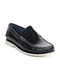

matched response is yes
The black shirt and the black shoes create a cohesive color scheme, while both items have a smart-casual style that is compatible for various occasions.


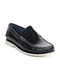

The items match!
The black shirt and the black shoes create a cohesive color scheme, while both items have a smart-casual style that is compatible for various occasions.


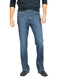

matched response is yes
The black shirt pairs well with the blue jeans, creating a classic and versatile look that is suitable for various seasons.


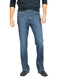

The items match!
The black shirt pairs well with the blue jeans, creating a classic and versatile look that is suitable for various seasons.


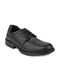

matched response is yes
Both items are in black, ensuring color harmony, and their styles are compatible for a smart-casual look.


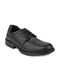

The items match!
Both items are in black, ensuring color harmony, and their styles are compatible for a smart-casual look.


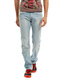

matched response is no
The shirt's color and style clash with the jeans' casual aesthetic, leading to a lack of harmony in the overall look.


In [256]:
# Select the unique paths for the generated images
paths = list(set(paths))
print(len(paths))

for path in paths:
    # Encode the test image to base64
    suggested_image = encode_image_to_base64(path)

    # Check if the items match
    match = json.loads(check_match(encoded_image, suggested_image))

    # Display all image and the analysis results
    display(Image(filename=path))
    print(f"matched response is {match["answer"]}")
    print(match["reason"])

    # Display the image and the analysis results
    if match["answer"] == 'yes':
        display(Image(filename=path))
        print("The items match!")
        print(match["reason"])

We can observe that the initial list of potential items has been further refined, resulting in a more curated selection that aligns well with the outfit. Additionally, the model provides explanations for why each item is considered a good match, offering valuable insights into the decision-making process.

### Conclusion

In this Jupyter Notebook, we explored the application of GPT-4 with Vision and other machine learning techniques to the domain of fashion. We demonstrated how to analyze images of clothing items, extract relevant features, and use this information to find matching items that complement an original outfit. Through the implementation of guardrails and self-correction mechanisms, we refined the model's suggestions to ensure they are accurate and contextually relevant.

This approach has several practical uses in the real world, including:

1. **Personalized Shopping Assistants**: Retailers can use this technology to offer personalized outfit recommendations to customers, enhancing the shopping experience and increasing customer satisfaction.
2. **Virtual Wardrobe Applications**: Users can upload images of their own clothing items to create a virtual wardrobe and receive suggestions for new items that match their existing pieces.
3. **Fashion Design and Styling**: Fashion designers and stylists can use this tool to experiment with different combinations and styles, streamlining the creative process.

However, one of the considerations to keep in mind is **cost**. The use of LLMs and image analysis models can incur costs, especially if used extensively. It's important to consider the cost-effectiveness of implementing these technologies. `gpt-4-vision-preview` is priced at `$0.01` per 1000 tokens. This adds up to `$0.00255` for one 256px x 256px image.

Overall, this notebook serves as a foundation for further exploration and development in the intersection of fashion and AI, opening doors to more personalized and intelligent fashion recommendation systems.